In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


## Stationnarité

### Variable Macro

In [ ]:
from statsmodels.tsa.stattools import adfuller

def tester_stationnarite_macro(df_macro, colonnes=None, verbose=True):
    """
    Teste la stationnarité (ADF) des colonnes d'un DataFrame macro.
    """
    if colonnes is None:
        colonnes = [col for col in df_macro.columns if col != "cod_prd_ref"]

    résultats = {}

    for col in colonnes:
        série = df_macro[col].dropna()
        try:
            adf_result = adfuller(série, regression='ct')  # regression='c' pour constante
            p_value = adf_result[1]
            résultats[col] = p_value
            if verbose:
                état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
                print(f"{col} : p-value = {p_value:.4f} → {état}")
        except Exception as e:
            résultats[col] = None
            print(f"{col} : ❌ Erreur lors du test ADF → {e}")

    return None
tester_stationnarite_macro(macro)


PIB : p-value = 0.0801 → ❌ Non stationnaire
IPL : p-value = 0.5321 → ❌ Non stationnaire
TCH : p-value = 0.6430 → ❌ Non stationnaire
Inflation : p-value = 0.7576 → ❌ Non stationnaire
PIB_diff1 : p-value = 0.0027 → ✅ Stationnaire
IPL_diff1 : p-value = 0.2559 → ❌ Non stationnaire
TCH_diff1 : p-value = 0.0000 → ✅ Stationnaire
Inflation_diff1 : p-value = 0.0051 → ✅ Stationnaire


In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import boxcox
import matplotlib.pyplot as plt

def tester_transformations_ipl(df, col="IPL_diff1"):
    série = df[col].dropna()
    résultats = {}

    # 1. ADF brut
    p_brute = adfuller(série, regression='ct')[1]
    résultats["Brute"] = p_brute

    # 2. Diff(2)
    try:
        diff2 = série.diff().dropna()
        résultats["Diff(2)"] = adfuller(diff2, regression='ct')[1]
    except:
        résultats["Diff(2)"] = None

    # 3. HP filter
    try:
        cycle, trend = hpfilter(série, lamb=1600)
        résultats["HP Cycle"] = adfuller(cycle.dropna(), regression='ct')[1]
    except:
        résultats["HP Cycle"] = None

    # 4. Log + Diff (si possible)
    try:
        if (série > 0).all():
            log_diff = np.log(série).diff().dropna()
            résultats["Log-Diff"] = adfuller(log_diff, regression='ct')[1]
        else:
            résultats["Log-Diff"] = None
    except:
        résultats["Log-Diff"] = None

    # 5. Box-Cox + Diff (si > 0)
    try:
        if (série > 0).all():
            bc_trans, _ = boxcox(série)
            bc_diff = pd.Series(bc_trans).diff().dropna()
            résultats["BoxCox-Diff"] = adfuller(bc_diff, regression='ct')[1]
        else:
            résultats["BoxCox-Diff"] = None
    except:
        résultats["BoxCox-Diff"] = None

    # Affichage des résultats
    print("\nRésultats ADF pour différentes transformations :")
    for k, p in résultats.items():
        if p is None:
            print(f"{k}: ❌ Erreur")
        else:
            état = "✅ Stationnaire" if p < 0.05 else "❌ Non stationnaire"
            print(f"{k}: p-value = {p:.4f} → {état}")

    return None
tester_transformations_ipl(macro)



Résultats ADF pour différentes transformations :
Brute: p-value = 0.2559 → ❌ Non stationnaire
Diff(2): p-value = 0.1891 → ❌ Non stationnaire
HP Cycle: p-value = 0.0035 → ✅ Stationnaire
Log-Diff: ❌ Erreur
BoxCox-Diff: ❌ Erreur


In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle_ipl, trend_ipl = hpfilter(macro["IPL_diff1"].dropna(), lamb=1600)
macro["IPL_diff1_hp"] = cycle_ipl


In [ ]:
macro.head()

,PIB,IPL,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,cod_prd_ref,IPL_diff1_hp
116,-1.286788,-1.624415,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,2009T1,-2.287187
117,-2.243102,-4.278729,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,2009T2,-2.418131
118,-3.012266,-6.103516,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,2009T3,-1.657648
119,-2.782833,-6.105367,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,2009T4,0.100615
120,-1.517665,-4.278209,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,2010T1,1.873299


### Variable pas macro

In [ ]:
segment.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522"
1,2009T1,2,"0,9185154","0,0150016761649346","0,13987106856808","0,237794752573896"
2,2009T1,3,"0,919842763","0,0188878742730812","0,0767728071889041","0,130521421454666"
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338"
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682"


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité de chaque segment (note_ref 1 à 5)
for i in range(1, 6):
    segment_i = segment[segment["note_ref"] == i].copy()

    # Conversion correcte des valeurs avec virgules en float
    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()
    except Exception as e:
        print(f"\n❌ Erreur conversion Segment {i} : {e}")
        continue

    print(f"\n🔎 Test ADF - Segment {i}")
    try:
        result = adfuller(series,regression='ct')
        p_value = result[1]
        if p_value < 0.05:
            print(f"✅ Stationnaire (p-value = {p_value:.4f})")
        else:
            print(f"❌ Non stationnaire (p-value = {p_value:.4f})")
    except Exception as e:
        print(f"⚠️ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF - Segment 1
✅ Stationnaire (p-value = 0.0001)

🔎 Test ADF - Segment 2
❌ Non stationnaire (p-value = 0.4601)

🔎 Test ADF - Segment 3
❌ Non stationnaire (p-value = 1.0000)

🔎 Test ADF - Segment 4
✅ Stationnaire (p-value = 0.0000)

🔎 Test ADF - Segment 5
✅ Stationnaire (p-value = 0.0000)


In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Liste des segments non stationnaires à transformer
segments_hp = [2, 3]

# Appliquer le HP filter et stocker le cycle dans une nouvelle colonne
for i in segments_hp:
    segment_i = segment[segment["note_ref"] == i].copy()

    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()

        # HP filter
        cycle, trend = hpfilter(series, lamb=1600)
        segment.loc[segment["note_ref"] == i, "cycle_hp"] = cycle.values

        print(f"✅ HP filter appliqué au segment {i}")
    except Exception as e:
        print(f"❌ Erreur pour le segment {i} : {e}")


✅ HP filter appliqué au segment 2
✅ HP filter appliqué au segment 3


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité des cycles HP filtrés pour les segments 2 et 3
for i in [2, 3]:
    series_hp = segment.loc[segment["note_ref"] == i, "cycle_hp"].dropna()
    print(f"\n🔎 Test ADF sur cycle HP - Segment {i}")

    if len(series_hp) < 10:
        print("⚠️ Trop peu de données pour appliquer ADF")
        continue

    try:
        p_value = adfuller(series_hp, regression="ct")[1]
        état = "✅ Stationnaire" if p_value < 0.05 else "❌ Non stationnaire"
        print(f"p-value = {p_value:.4f} → {état}")
    except Exception as e:
        print(f"❌ Erreur ADF pour le segment {i} : {e}")



🔎 Test ADF sur cycle HP - Segment 2
p-value = 0.0429 → ✅ Stationnaire

🔎 Test ADF sur cycle HP - Segment 3
p-value = 0.0000 → ✅ Stationnaire


On recommence mtn qu'on sait qui est stationnaire ou non 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2_contingency
import seaborn as sns


In [4]:
segment = pd.read_csv(r"data\brutes\Données_CCF_PAR_SEGMENT.csv",sep=";")
segment.head()
macro = pd.read_excel(r"data\brutes\historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx")
macro["date_dernier_mois"] = pd.to_datetime(macro["date_dernier_mois"], format="%Y-%m")
macro["cod_prd_ref"] = macro["date_dernier_mois"].dt.year.astype(str) + "T" + macro["date_dernier_mois"].dt.quarter.astype(str)
macro.drop(columns=["date_dernier_mois"], inplace=True)
macro = macro[macro["cod_prd_ref"] >= '2009T1']


In [5]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle_ipl, trend_ipl = hpfilter(macro["IPL_diff1"].dropna(), lamb=1600)
macro["IPL_diff1_hp"] = cycle_ipl


In [6]:
from statsmodels.tsa.filters.hp_filter import hpfilter

segments_hp = [2, 3]

for i in segments_hp:
    segment_i = segment[segment["note_ref"] == i].copy()

    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()

        cycle, trend = hpfilter(series, lamb=1600)
        segment.loc[segment["note_ref"] == i, "cycle_hp"] = cycle.values

        print(f"✅ HP filter appliqué au segment {i}")
    except Exception as e:
        print(f"❌ Erreur pour le segment {i} : {e}")


✅ HP filter appliqué au segment 2
✅ HP filter appliqué au segment 3


In [7]:
segment["Indicateur_moyen_Brut"] = segment.apply(
    lambda row: row["cycle_hp"] if row["note_ref"] in [2, 3] else row["Indicateur_moyen_Brut"],
    axis=1
)


In [8]:
segment["cod_prd_ref"] = segment["cod_prd_ref"].astype(str).str.strip()
macro["cod_prd_ref"] = macro["cod_prd_ref"].astype(str).str.strip()

In [9]:
df_merged = pd.merge(segment, macro, on="cod_prd_ref", how="left")
colonnes_a_supprimer = ['cycle_hp', 'PIB_diff1','IPL', 'TCH', 'Inflation', 'IPL_diff1']
df = df_merged.drop(columns=colonnes_a_supprimer)
df.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'PIB', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [10]:
segment_1 =df[df["note_ref"] == 1].copy()
segment_2 =df[df["note_ref"] == 2].copy()
segment_3 =df[df["note_ref"] == 3].copy()
segment_4 =df[df["note_ref"] == 4].copy()
segment_5 =df[df["note_ref"] == 5].copy()

In [11]:
df.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",-1.286788,0.9,-0.697982,-2.287187
1,2009T1,2,0.139372,"0,0150016761649346","0,13987106856808","0,237794752573896",-1.286788,0.9,-0.697982,-2.287187
2,2009T1,3,-0.001619,"0,0188878742730812","0,0767728071889041","0,130521421454666",-1.286788,0.9,-0.697982,-2.287187
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",-1.286788,0.9,-0.697982,-2.287187
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682",-1.286788,0.9,-0.697982,-2.287187


In [12]:
def convertir_cod_prd_ref_en_date(df):
    df = df.copy()

    # Convertir "2020T1" → "2020Q1" pour PeriodIndex
    df["period"] = df["cod_prd_ref"].str.replace("T", "Q")

    # Créer une colonne PeriodIndex
    df["period"] = pd.PeriodIndex(df["period"], freq="Q")

    # Créer une date de début de trimestre
    df["date"] = pd.to_datetime(df["period"].astype(str))

    # Extraire année / trimestre correctement
    df["year"] = df["period"].dt.year
    df["quarter"] = df["period"].dt.quarter

    return df


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np

def enrichir_variables_macro(df):
    df = df.copy()

    # === Date en datetime ===
    df["date"] = pd.to_datetime(df["date"])

    # === Lags ===
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)

    df["PIB_lag2"] = df["PIB"].shift(2)
    df["TCH_diff1_lag2"] = df["TCH_diff1"].shift(2)
    df["Inflation_diff1_lag2"] = df["Inflation_diff1"].shift(2)
    df["IPL_diff1_hp_lag2"] = df["IPL_diff1_hp"].shift(2)

    # === Moyennes mobiles ===
    df["PIB_ma3"] = df["PIB"].rolling(window=3).mean()
    df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
    df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
    df["IPL_ma3"] = df["IPL_diff1_hp"].rolling(window=3).mean()

    df["PIB_ma5"] = df["PIB"].rolling(window=5).mean()
    df["TCH_ma5"] = df["TCH_diff1"].rolling(window=5).mean()
    df["Inflation_ma5"] = df["Inflation_diff1"].rolling(window=5).mean()
    df["IPL_ma5"] = df["IPL_diff1_hp"].rolling(window=5).mean()

    # === Interactions ===
    df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]
    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]
    df["PIB_x_TCH_ma3"] = df["PIB"] * df["TCH_diff1"].rolling(3).mean()

    # === Puissances ===
    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    # === Nouveaux indicateurs temporels / structurels ===
    df["year"] = df["date"].dt.year
    df["quarter"] = df["date"].dt.quarter
    df["is_covid"] = ((df["date"] >= "2020-03-01") & (df["date"] <= "2021-06-30")).astype(int)
    df["post_covid"] = (df["date"] >= "2021-07-01").astype(int)

    # === Transformations supplémentaires ===
    df["PIB_pct_change"] = df["PIB"].pct_change()
    df["TCH_diff1_abs"] = df["TCH_diff1"].abs()
    df["PIB_x_TCH_squared"] = df["PIB"] * (df["TCH_diff1"] ** 2)

    df = df.dropna().reset_index(drop=True)

    print(f"🧪 Données enrichies : {df.shape[1]} variables disponibles.")
    return df

# === Sélection automatique de variables pertinentes ===
def select_features_via_random_forest(df, target_col="Indicateur_moyen_Brut", n_estimators=100):
    X = df.drop(columns=["date", target_col])
    y = df[target_col].astype(str).str.replace(",", ".").astype(float)

    X = X.select_dtypes(include=[np.number]).fillna(0)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    selector = SelectFromModel(model).fit(X, y)

    selected_vars = list(X.columns[selector.get_support()])
    print(f"🎯 Variables sélectionnées ({len(selected_vars)}):", selected_vars)
    return selected_vars


In [14]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
from sklearn.feature_selection import SelectFromModel

# Créer dossier de sauvegarde
os.makedirs("models", exist_ok=True)

résumé_segments = []

for i, df_seg in enumerate([segment_1, segment_2, segment_3, segment_4, segment_5], start=1):
    print(f"\n{'='*60}")
    print(f"🔁 Traitement du segment {i}")

    try:
        df_seg = convertir_cod_prd_ref_en_date(df_seg)
        df_enrichi = enrichir_variables_macro(df_seg)

        df_enrichi["Indicateur_moyen_Brut"] = (
            df_enrichi["Indicateur_moyen_Brut"]
            .astype(str).str.replace(",", ".").astype(float)
        )

        X_all = df_enrichi.drop(columns=["date", "Indicateur_moyen_Brut"])
        y_all = df_enrichi["Indicateur_moyen_Brut"]
        X_all = X_all.select_dtypes(include=[np.number]).fillna(0)

        selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=0))
        selector.fit(X_all, y_all)
        top_vars = list(X_all.columns[selector.get_support()])

        # === Entraînement RF ===
        X = df_enrichi[top_vars].fillna(0)
        y = df_enrichi["Indicateur_moyen_Brut"]
        model_rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X, y)
        r2_rf = model_rf.score(X, y)

        # === Entraînement OLS
# === Entraînement OLS
        X_ols = sm.add_constant(X)
        model_ols = sm.OLS(y, X_ols).fit()
        r2_ols = model_ols.rsquared
        joblib.dump((model_ols, top_vars), f"models/ols_segment_{i}.joblib")  # ici


        # === Tests MCO
        dw = durbin_watson(model_ols.resid)
        bp_p = het_breuschpagan(model_ols.resid, X_ols)[1]
        shap_p = shapiro(model_ols.resid)[1]
        jb_p = jarque_bera(model_ols.resid)[1]

        violations = []
        if not (1.5 <= dw <= 2.5):
            violations.append("DW")
        if bp_p <= 0.05:
            violations.append("BP")
        if shap_p <= 0.05:
            violations.append("Shapiro")
        if jb_p <= 0.05:
            violations.append("JB")

        résumé_segments.append({
            "Segment": i,
            "R²_RF": round(r2_rf, 3),
            "R²_OLS": round(r2_ols, 3),
            "Hypothèses non respectées": ", ".join(violations) if violations else "Aucune",
            "Variables utilisées": ", ".join(top_vars)
        })

        joblib.dump((model_rf, top_vars), f"models/random_forest_segment_{i}.joblib")
        print(f"✅ Segment {i} – RF R² = {r2_rf:.3f} – OLS R² = {r2_ols:.3f}")


    except Exception as e:
        print(f"❌ Erreur segment {i} : {e}")



🔁 Traitement du segment 1
🧪 Données enrichies : 44 variables disponibles.


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\844307301.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["period"].astype(str))


✅ Segment 1 – RF R² = 0.906 – OLS R² = 0.487

🔁 Traitement du segment 2
🧪 Données enrichies : 44 variables disponibles.


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\844307301.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["period"].astype(str))


✅ Segment 2 – RF R² = 0.882 – OLS R² = 0.405

🔁 Traitement du segment 3
🧪 Données enrichies : 44 variables disponibles.


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\844307301.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["period"].astype(str))


✅ Segment 3 – RF R² = 0.853 – OLS R² = 0.406

🔁 Traitement du segment 4
🧪 Données enrichies : 44 variables disponibles.


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\844307301.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["period"].astype(str))


✅ Segment 4 – RF R² = 0.903 – OLS R² = 0.651

🔁 Traitement du segment 5
🧪 Données enrichies : 44 variables disponibles.


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\844307301.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["period"].astype(str))


✅ Segment 5 – RF R² = 0.881 – OLS R² = 0.260


In [15]:
os.makedirs("models/rf", exist_ok=True)
os.makedirs("models/ols", exist_ok=True)
# Puis :
joblib.dump((model_rf, top_vars), f"models/rf/segment_{i}.joblib")
joblib.dump((model_ols, top_vars), f"models/ols/segment_{i}.joblib")


['models/ols/segment_5.joblib']

In [16]:
df_résumé = pd.DataFrame(résumé_segments)
display(df_résumé)


,Segment,R²_RF,R²_OLS,Hypothèses non respectées,Variables utilisées
0,1,0.906,0.487,"DW, Shapiro","IPL_diff1_hp, year, IPL_diff1_hp_lag1, Inflati..."
1,2,0.882,0.405,Aucune,"Inflation_diff1, PIB_lag1, Inflation_diff1_lag..."
2,3,0.853,0.406,Aucune,"Inflation_diff1, IPL_diff1_hp, quarter, IPL_di..."
3,4,0.903,0.651,Aucune,"IPL_diff1_hp, year, PIB_lag2, TCH_diff1_lag2, ..."
4,5,0.881,0.260,"DW, Shapiro, JB","year, Inflation_diff1_lag1, TCH_ma3, TCH_ma5"


In [17]:
df_résumé

,Segment,R²_RF,R²_OLS,Hypothèses non respectées,Variables utilisées
0,1,0.906,0.487,"DW, Shapiro","IPL_diff1_hp, year, IPL_diff1_hp_lag1, Inflati..."
1,2,0.882,0.405,Aucune,"Inflation_diff1, PIB_lag1, Inflation_diff1_lag..."
2,3,0.853,0.406,Aucune,"Inflation_diff1, IPL_diff1_hp, quarter, IPL_di..."
3,4,0.903,0.651,Aucune,"IPL_diff1_hp, year, PIB_lag2, TCH_diff1_lag2, ..."
4,5,0.881,0.260,"DW, Shapiro, JB","year, Inflation_diff1_lag1, TCH_ma3, TCH_ma5"


In [18]:
import pandas as pd

# Charger uniquement la feuille CENT du fichier
df_raw  = pd.read_excel(r"data\Scenario_horizon3ans_propre.xlsx")



In [19]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

# === Étape 1 : fonction de transformation d’un scénario brut ===
def prepare_scenario(df_raw, prefix):
    df = df_raw[["date", f"PIB_{prefix}", f"IPL_{prefix}", f"TCH_{prefix}", f"Inflation_{prefix}"]].copy()
    df.columns = ["date", "PIB", "IPL", "TCH", "Inflation"]

    df["PIB_diff1"] = df["PIB"].diff()
    df["TCH_diff1"] = df["TCH"].diff()
    df["Inflation_diff1"] = df["Inflation"].diff()
    df["IPL_diff1"] = df["IPL"].diff()

    df["IPL_diff1_hp"] = np.nan
    ipl_valid = df["IPL_diff1"].dropna()
    cycle_ipl, _ = hpfilter(ipl_valid, lamb=1600)
    df.loc[ipl_valid.index, "IPL_diff1_hp"] = cycle_ipl


    return df.dropna().reset_index(drop=True)

# === Étape 2 : enrichissement macro complet ===
def enrichir_macro_scenario(df):
    df = df.copy()

    # === Lags
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["PIB_lag2"] = df["PIB"].shift(2)
    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["TCH_diff1_lag2"] = df["TCH_diff1"].shift(2)
    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["Inflation_diff1_lag2"] = df["Inflation_diff1"].shift(2)
    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)
    df["IPL_diff1_hp_lag2"] = df["IPL_diff1_hp"].shift(2)

    # === Moyennes mobiles
    df["PIB_ma3"] = df["PIB"].rolling(3).mean()
    df["PIB_ma5"] = df["PIB"].rolling(5).mean()
    df["TCH_ma3"] = df["TCH_diff1"].rolling(3).mean()
    df["TCH_ma5"] = df["TCH_diff1"].rolling(5).mean()
    df["Inflation_ma5"] = df["Inflation_diff1"].rolling(5).mean()
    df["IPL_ma3"] = df["IPL_diff1_hp"].rolling(3).mean()
    df["IPL_ma5"] = df["IPL_diff1_hp"].rolling(5).mean()

    # === Transformations
    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    # === Interactions
    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]
    df["PIB_x_TCH_ma3"] = df["PIB"] * df["TCH_diff1"].rolling(3).mean()
    df["PIB_x_TCH_squared"] = df["PIB"] * (df["TCH_diff1"] ** 2)

    # === Variables temporelles
    df["year"] = pd.to_datetime(df["date"]).dt.year
    df["quarter"] = pd.to_datetime(df["date"]).dt.quarter
    df["PIB_pct_change"] = df["PIB"].pct_change()

    return df.dropna().reset_index(drop=True)

# === Étape 3 : features par segment ===
top_features_dict = {
    1: ['IPL_diff1_hp', 'year', 'IPL_diff1_hp_lag1', 'Inflation_diff1_lag2',
        'IPL_diff1_hp_lag2', 'PIB_ma5', 'Inflation_ma5', 'IPL_ma5',
        'PIB_x_Inflation', 'TCH_x_IPL', 'PIB_x_TCH_ma3', 'PIB_squared'],
    2: ['Inflation_diff1', 'PIB_lag1', 'Inflation_diff1_lag1', 'PIB_lag2',
        'Inflation_diff1_lag2', 'IPL_diff1_hp_lag2', 'PIB_ma3', 'PIB_ma5',
        'Inflation_ma5', 'Inflation_x_IPL', 'PIB_x_TCH_ma3', 'PIB_x_TCH_squared'],
    3: ['Inflation_diff1', 'IPL_diff1_hp', 'quarter', 'IPL_diff1_hp_lag1',
        'Inflation_diff1_lag2', 'TCH_ma5', 'PIB_x_Inflation', 'TCH_x_IPL',
        'Inflation_x_IPL', 'PIB_x_TCH_ma3', 'PIB_squared', 'Inflation_diff1_squared',
        'IPL_diff1_hp_squared', 'PIB_pct_change', 'PIB_x_TCH_squared'],
    4: ['IPL_diff1_hp', 'year', 'PIB_lag2', 'TCH_diff1_lag2', 'Inflation_diff1_lag2',
        'IPL_diff1_hp_lag2', 'TCH_ma3', 'IPL_ma3', 'TCH_ma5', 'IPL_ma5',
        'TCH_x_IPL', 'PIB_x_TCH_ma3'],
    5: ['year', 'Inflation_diff1_lag1', 'TCH_ma3', 'TCH_ma5']
}


# === Étape 4 : prédiction multi-scenarios ===
def predict_all_scenarios(df_raw, scenarios=["CENT", "PESS", "OPT"]):
    results = {}

    for scenario in scenarios:
        print(f"\n🔮 Scénario : {scenario}")
        df_prepared = prepare_scenario(df_raw, scenario)
        df_enriched = enrichir_macro_scenario(df_prepared)
        scenario_results = {}

        for seg in range(1, 6):
            try:
                model = joblib.load(f"models/random_forest_segment_{seg}.joblib")[0]
                top_features = top_features_dict[seg]

                X = df_enriched[top_features].astype(float).dropna()
                y_pred = model.predict(X)

                df_result = df_enriched.loc[X.index].copy()
                df_result["CCF_prédit"] = y_pred
                scenario_results[seg] = df_result

                print(f"✅ Segment {seg} – {len(y_pred)} prédictions")

                # Affichage
                plt.figure(figsize=(10, 4))
                plt.plot(df_result["date"], df_result["CCF_prédit"], marker='o')
                plt.title(f"{scenario} – Segment {seg} – CCF projeté")
                plt.xlabel("Date")
                plt.ylabel("CCF prédite")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Segment {seg} – erreur : {e}")

        results[scenario] = scenario_results

    return results



def predict_all_models_scenarios(df_raw, scenarios=["CENT", "PESS", "OPT"]):
    results = {}

    for scenario in scenarios:
        print(f"\n🔮 Scénario : {scenario}")
        df_prepared = prepare_scenario(df_raw, scenario)
        df_enriched = enrichir_macro_scenario(df_prepared)
        scenario_results = {}

        for seg in range(1, 6):
            try:
                # Charger modèles + features
                model_rf, top_features_rf = joblib.load(f"models/random_forest_segment_{seg}.joblib")
                model_ols, top_features_ols = joblib.load(f"models/ols_segment_{seg}.joblib")

                # Préparer X
                X_rf = df_enriched[top_features_rf].astype(float).dropna()
                X_ols = df_enriched[top_features_ols].astype(float).dropna()
                X_ols_const = sm.add_constant(X_ols)

                # Prédictions
                y_pred_rf = model_rf.predict(X_rf)
                y_pred_ols = model_ols.predict(X_ols_const)

                # Résultats communs
                idx_common = X_rf.index.intersection(X_ols.index)
                df_result = df_enriched.loc[idx_common].copy()
                df_result["CCF_RF"] = y_pred_rf[:len(idx_common)]
                df_result["CCF_OLS"] = y_pred_ols[:len(idx_common)]

                # Stocker
                scenario_results[seg] = df_result
                print(f"✅ Segment {seg} – {len(idx_common)} prédictions")

                # Affichage
                plt.figure(figsize=(10, 4))
                plt.plot(df_result["date"], df_result["CCF_RF"], label="RF", linestyle="-", marker="x")
                plt.plot(df_result["date"], df_result["CCF_OLS"], label="OLS", linestyle="--", marker="o")
                plt.title(f"{scenario} – Segment {seg} – CCF projeté (RF vs OLS)")
                plt.xlabel("Date")
                plt.ylabel("CCF prédite")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Segment {seg} – erreur : {e}")

        results[scenario] = scenario_results

    return results




🔮 Scénario : CENT
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


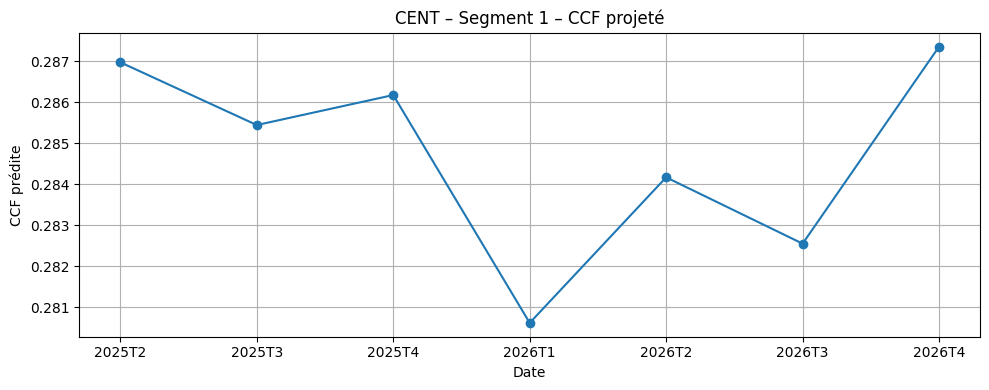

✅ Segment 2 – 7 prédictions


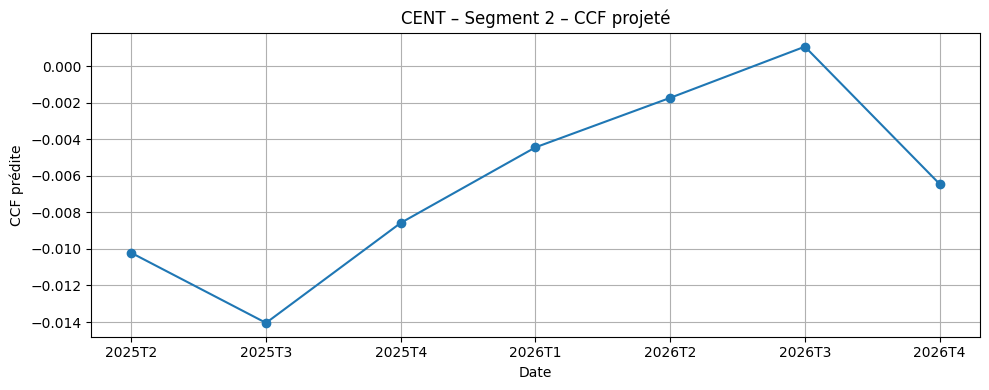

✅ Segment 3 – 7 prédictions


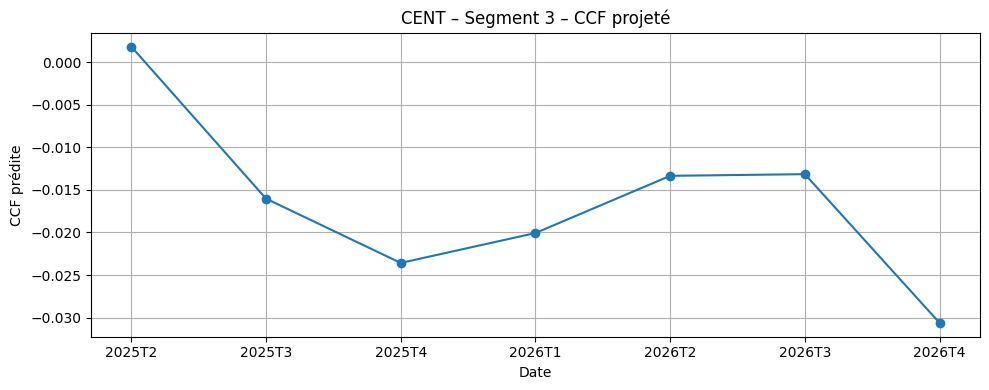

✅ Segment 4 – 7 prédictions


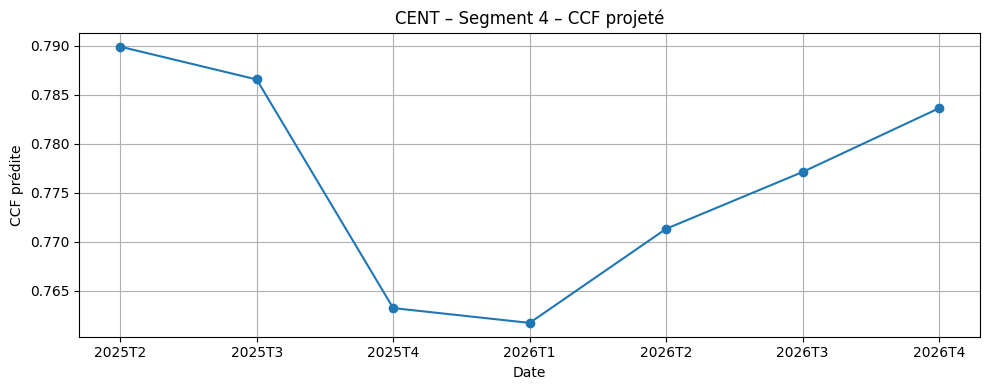

✅ Segment 5 – 7 prédictions


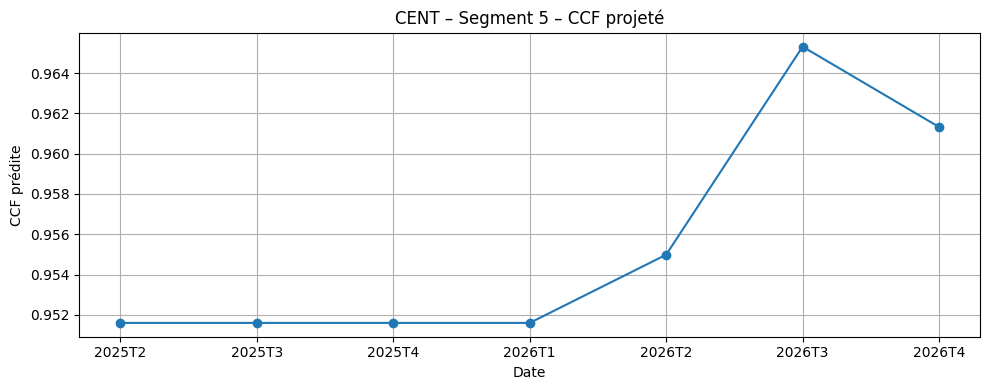


🔮 Scénario : PESS
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


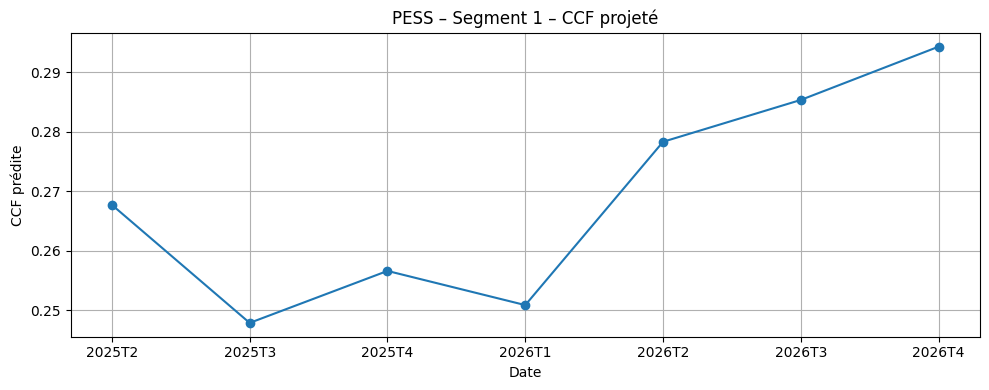

✅ Segment 2 – 7 prédictions


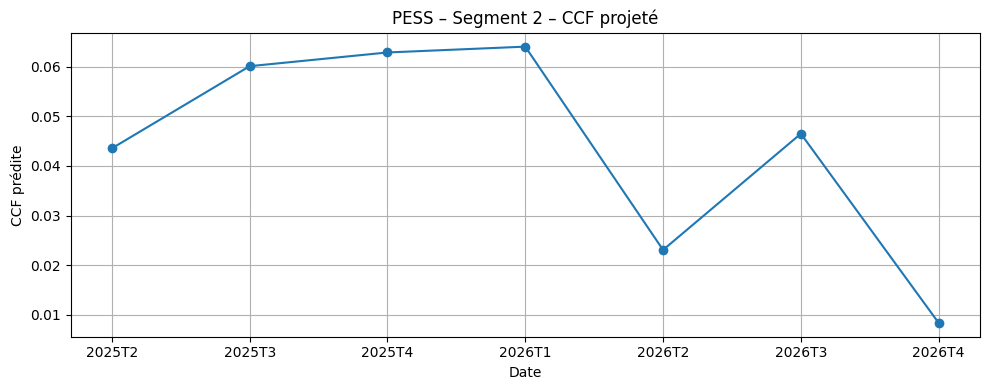

✅ Segment 3 – 7 prédictions


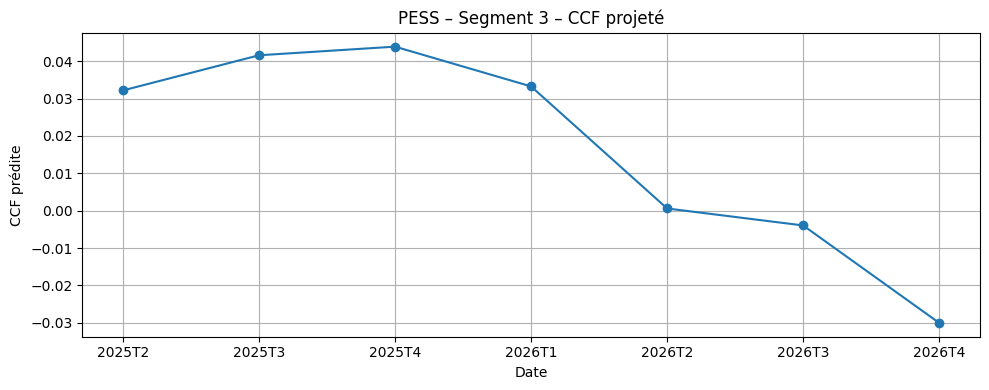

✅ Segment 4 – 7 prédictions


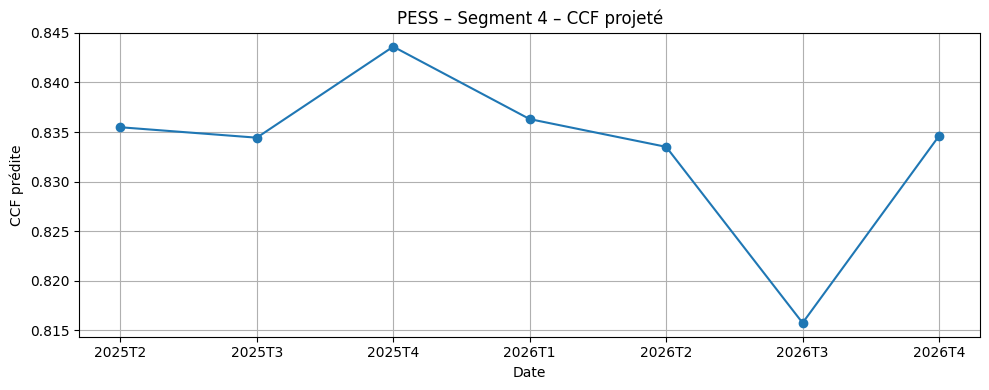

✅ Segment 5 – 7 prédictions


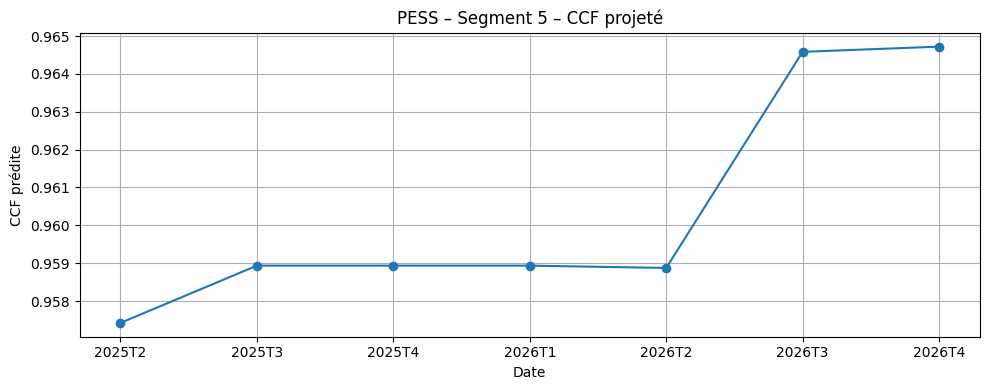


🔮 Scénario : OPT
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


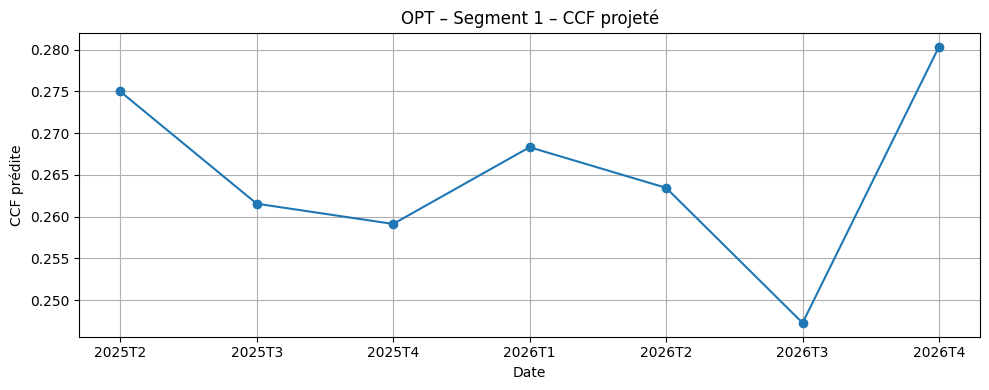

✅ Segment 2 – 7 prédictions


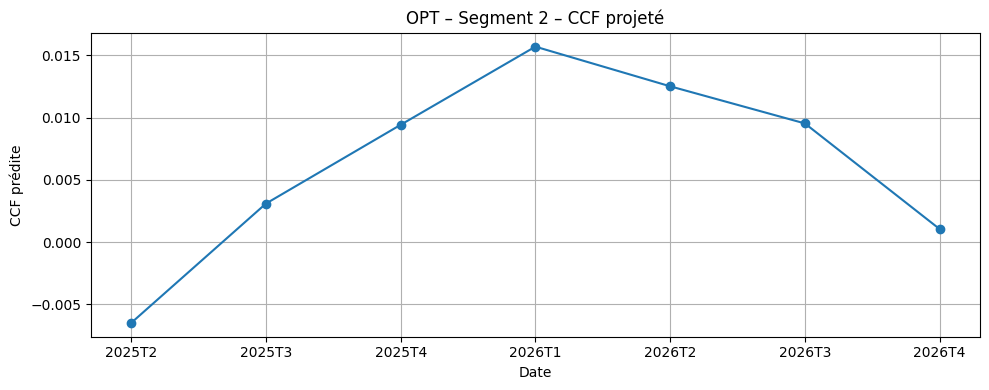

✅ Segment 3 – 7 prédictions


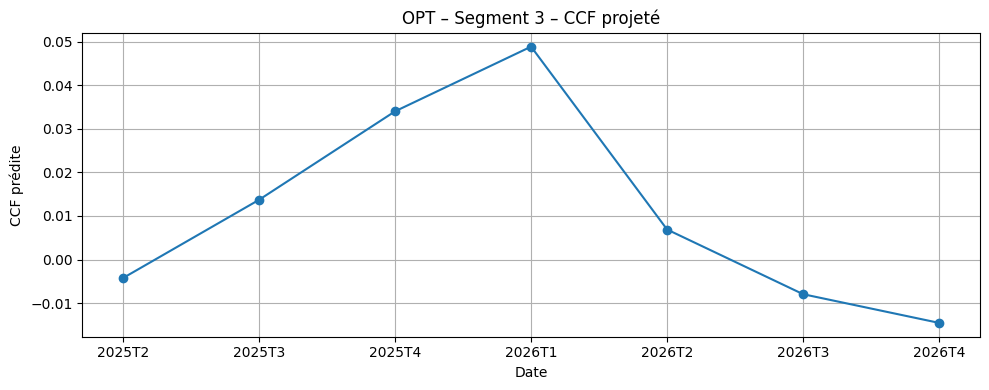

✅ Segment 4 – 7 prédictions


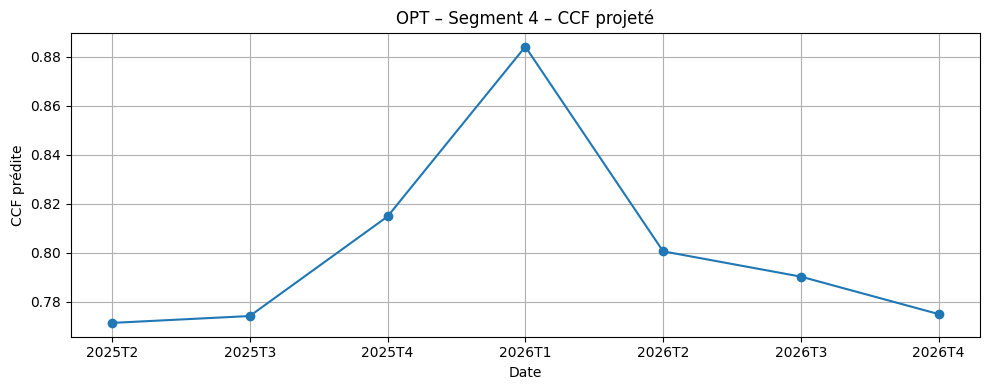

✅ Segment 5 – 7 prédictions


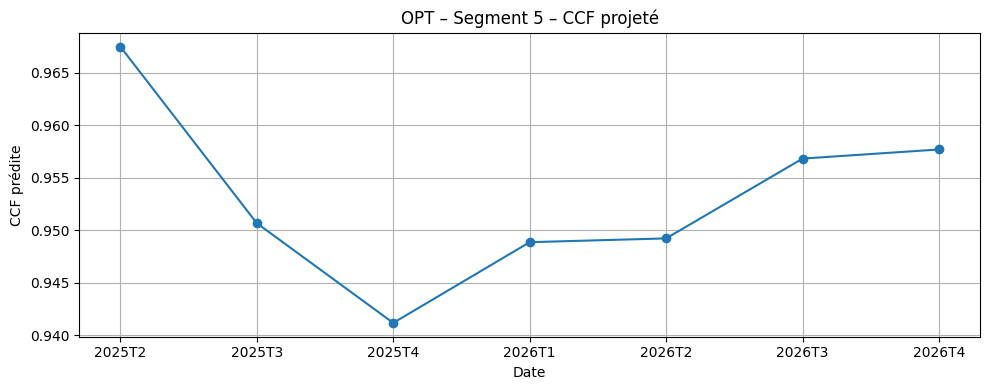

In [20]:
# Charger le fichier macro

# Exécution multi-scenarios
results_scenarios = predict_all_scenarios(df_raw)



🔮 Scénario : CENT
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


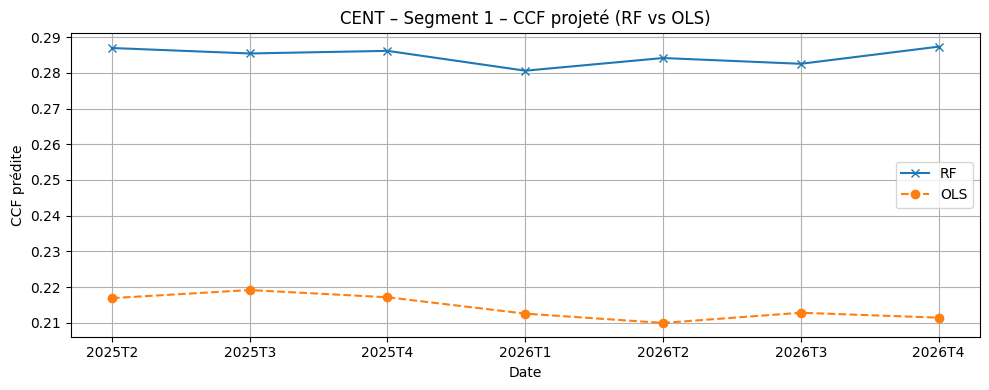

✅ Segment 2 – 7 prédictions


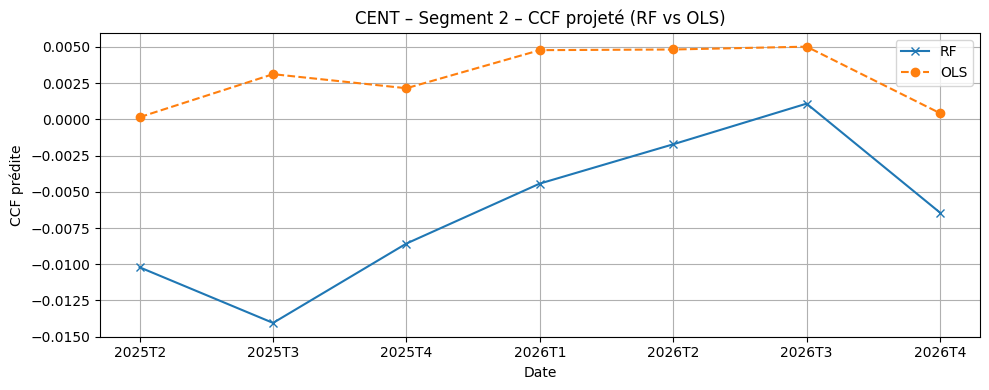

✅ Segment 3 – 7 prédictions


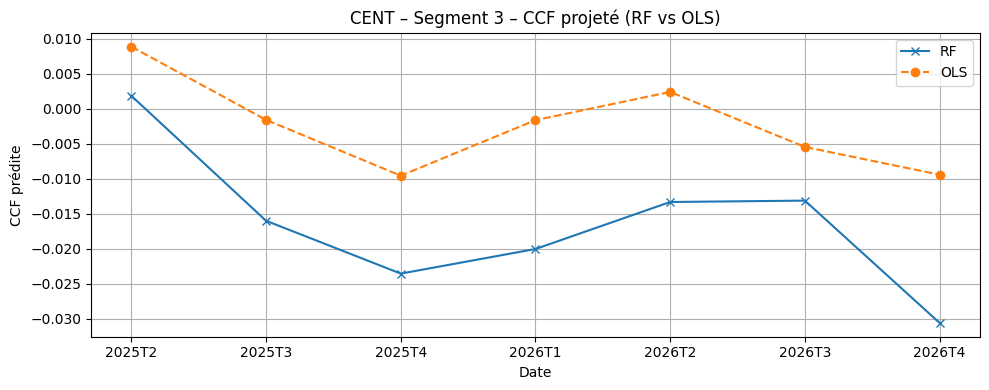

✅ Segment 4 – 7 prédictions


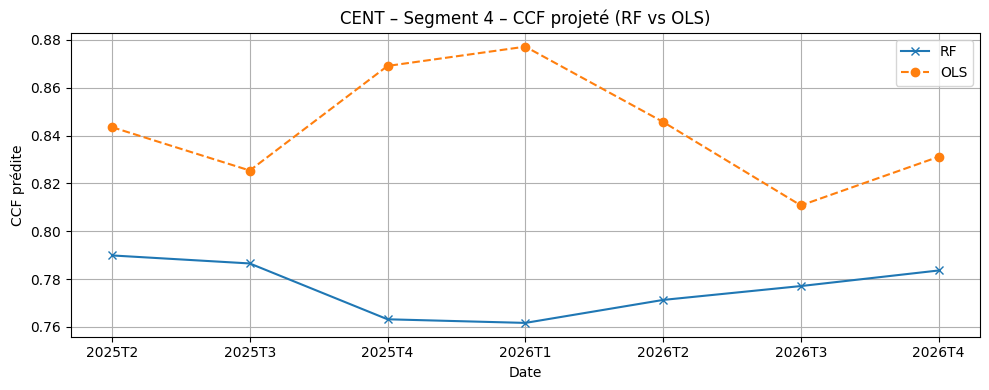

✅ Segment 5 – 7 prédictions


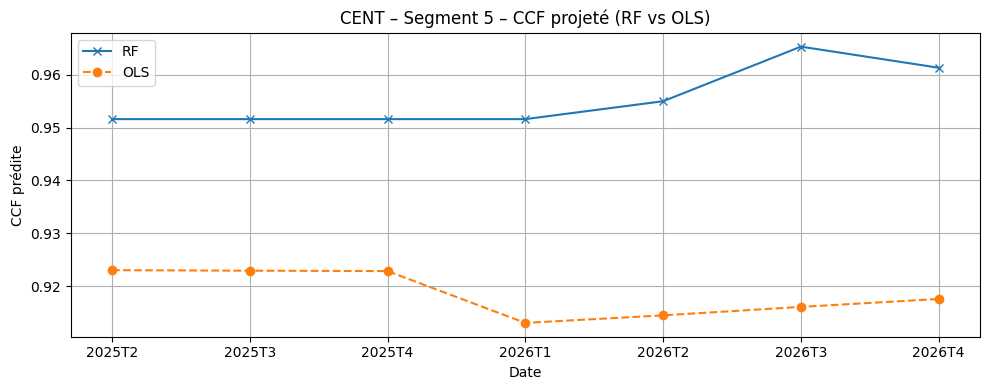


🔮 Scénario : PESS
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


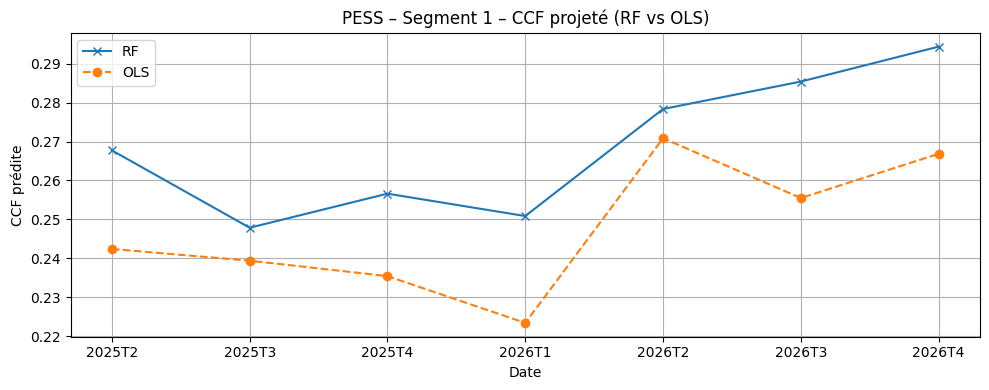

✅ Segment 2 – 7 prédictions


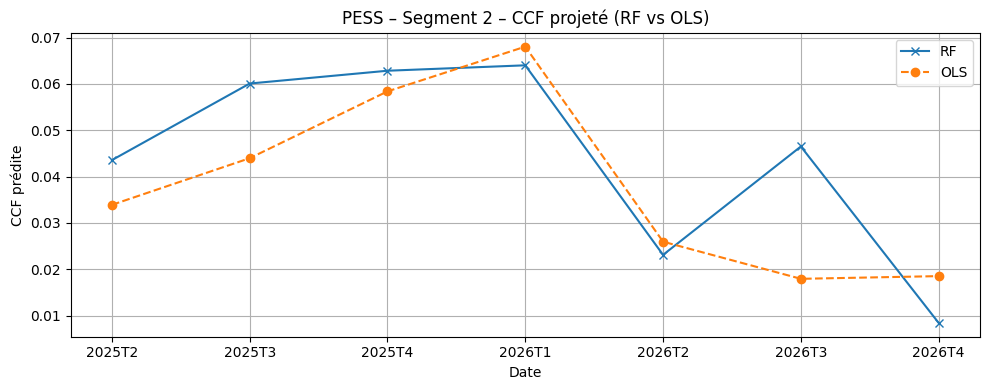

✅ Segment 3 – 7 prédictions


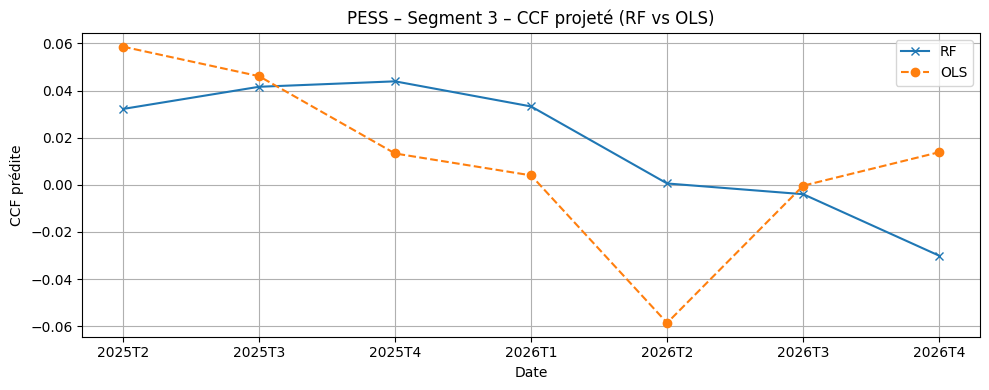

✅ Segment 4 – 7 prédictions


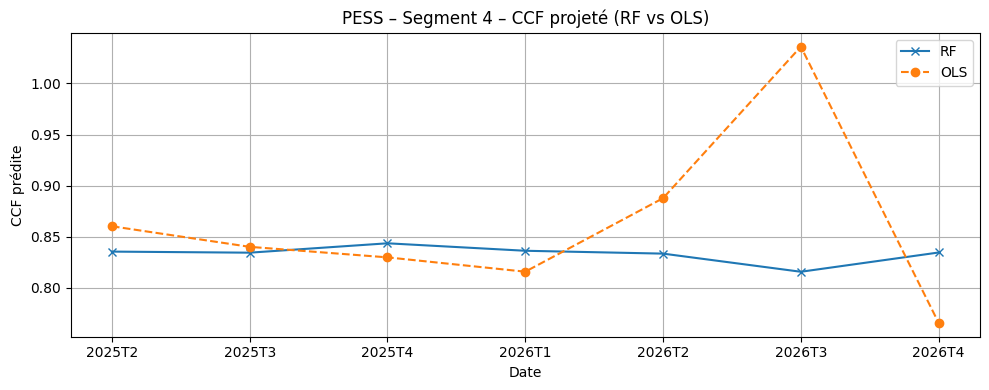

✅ Segment 5 – 7 prédictions


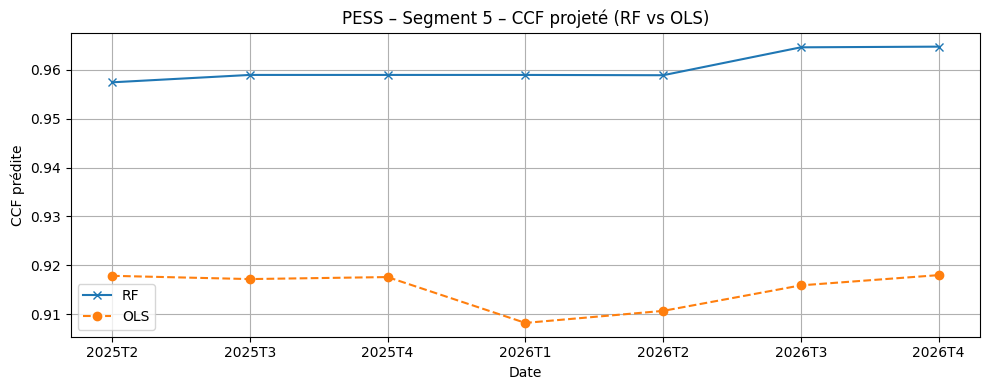


🔮 Scénario : OPT
✅ Segment 1 – 7 prédictions


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["year"] = pd.to_datetime(df["date"]).dt.year
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\126672164.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["quarter"] = pd.to_datetime(df["date"]).dt.quarter


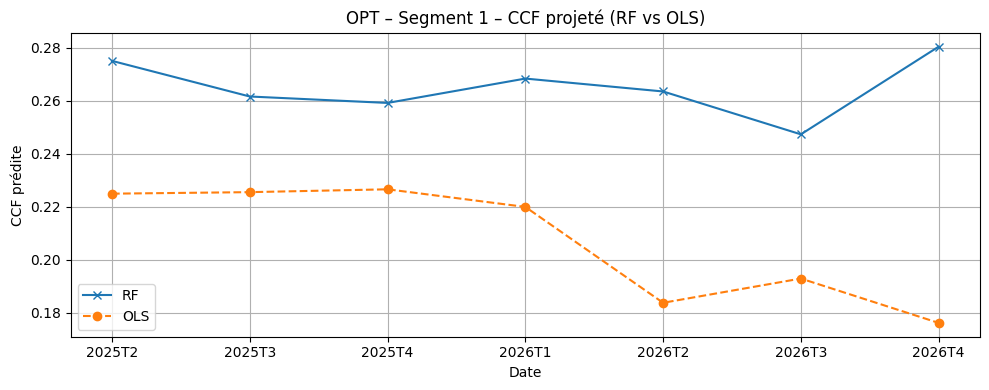

✅ Segment 2 – 7 prédictions


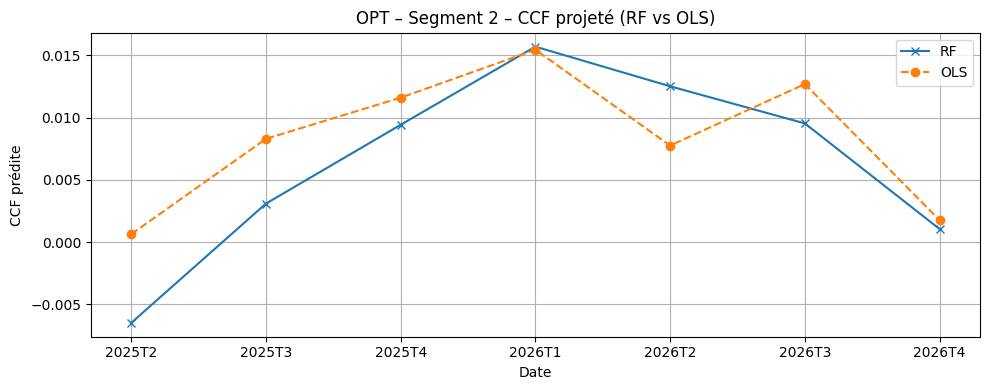

✅ Segment 3 – 7 prédictions


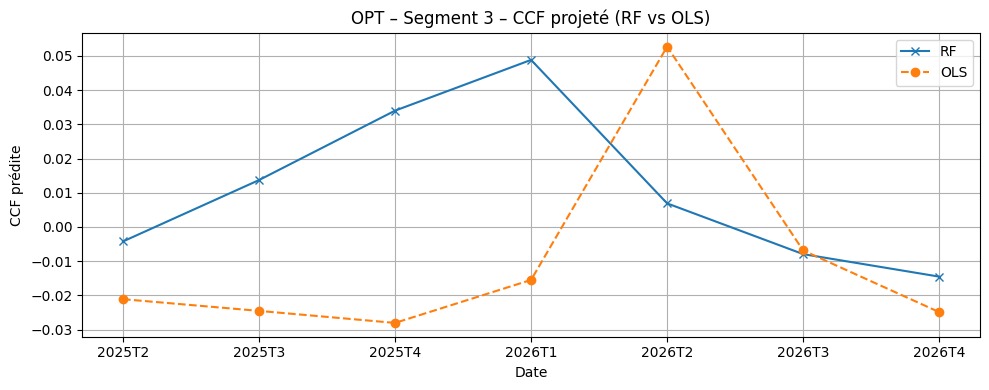

✅ Segment 4 – 7 prédictions


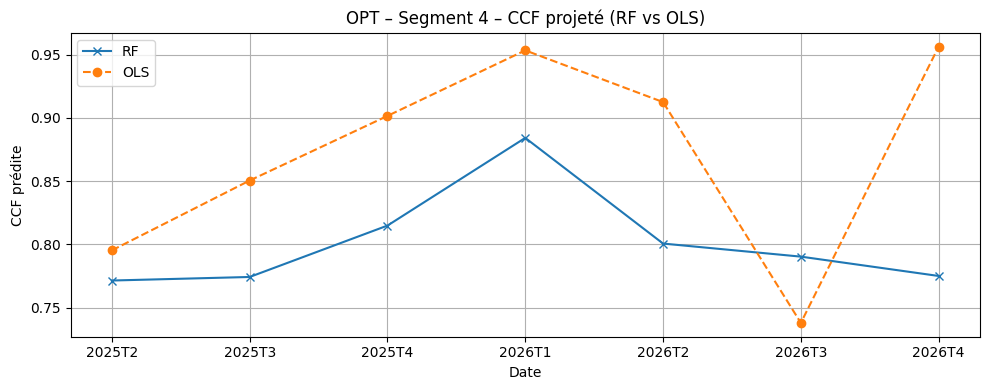

✅ Segment 5 – 7 prédictions


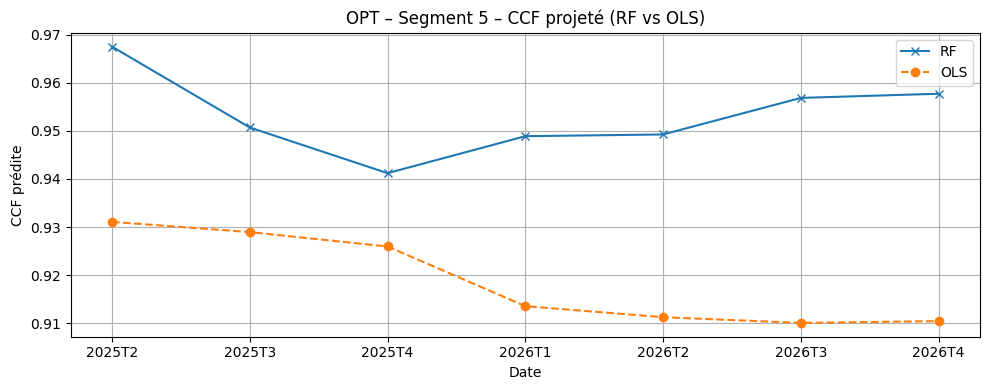

In [21]:
results_models = predict_all_models_scenarios(df_raw)


In [22]:
segments = {
    1: segment_1,
    2: segment_2,
    3: segment_3,
    4: segment_4,
    5: segment_5
}


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parse

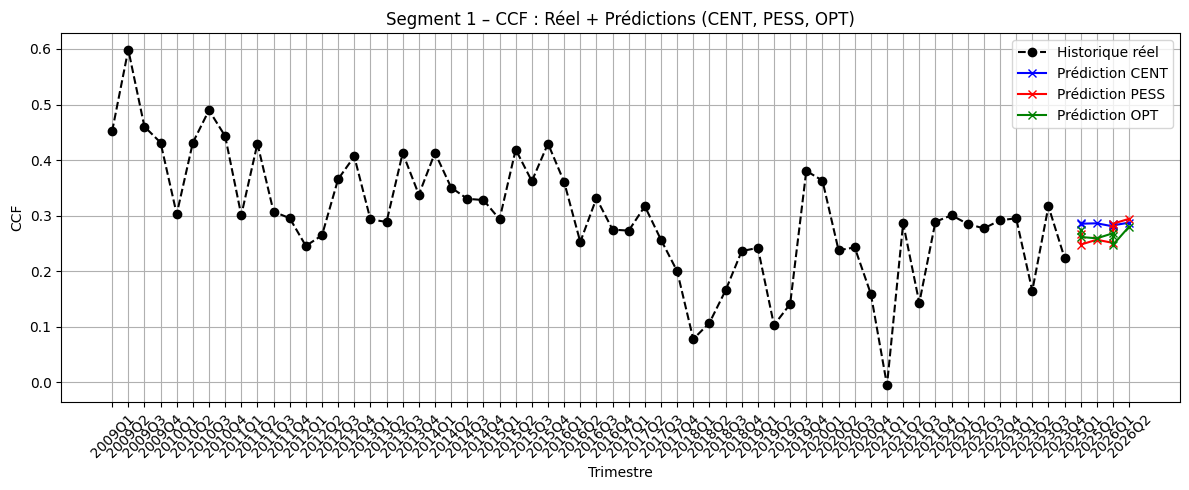

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parse

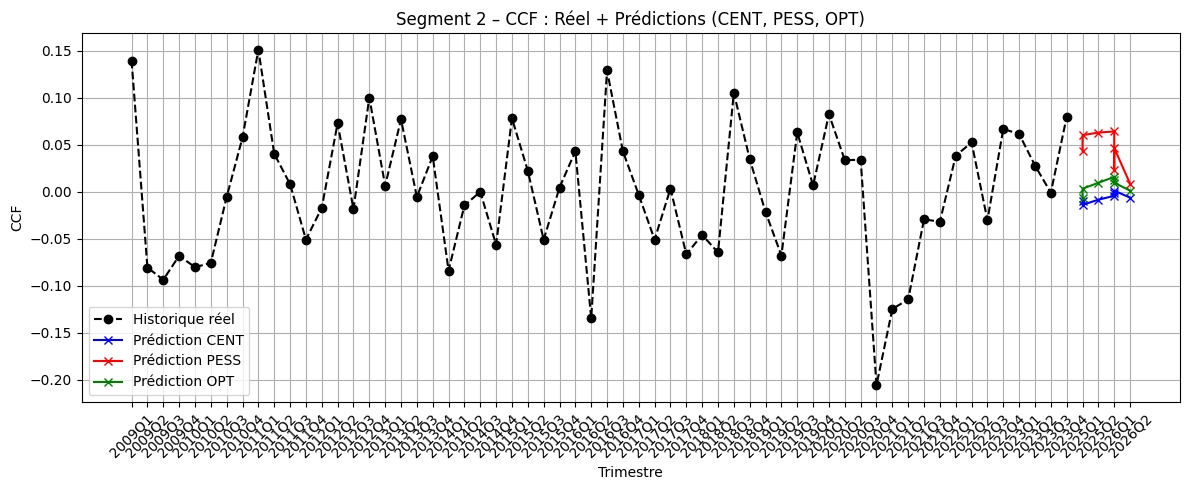

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parse

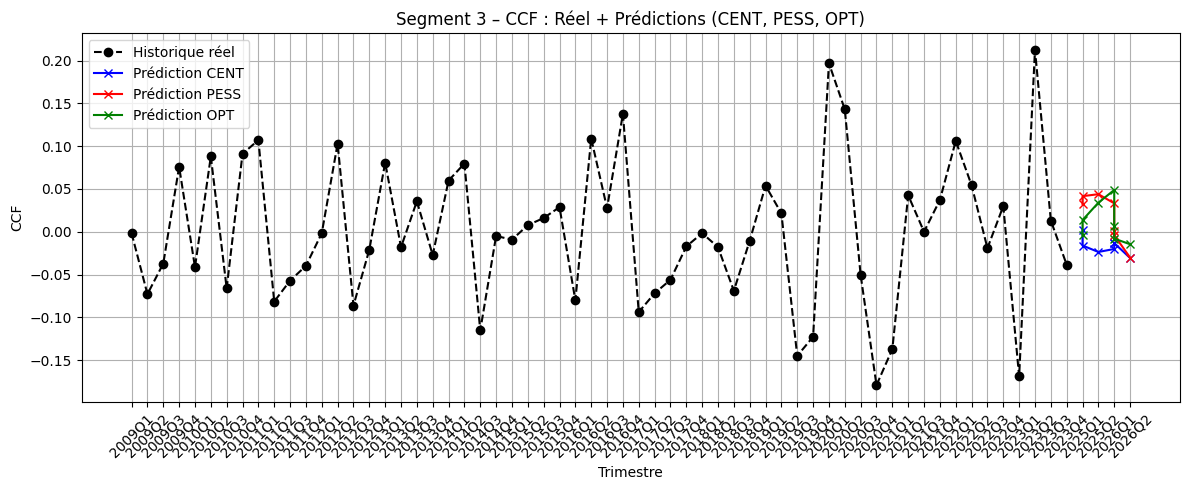

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parse

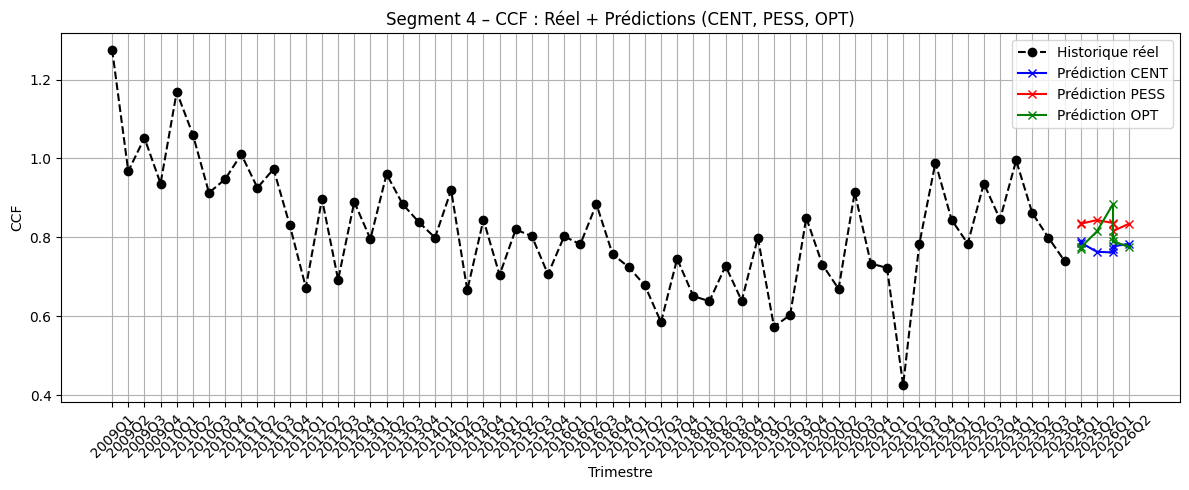

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\3900197163.py:40: UserWarning: Could not infer format, so each element will be parse

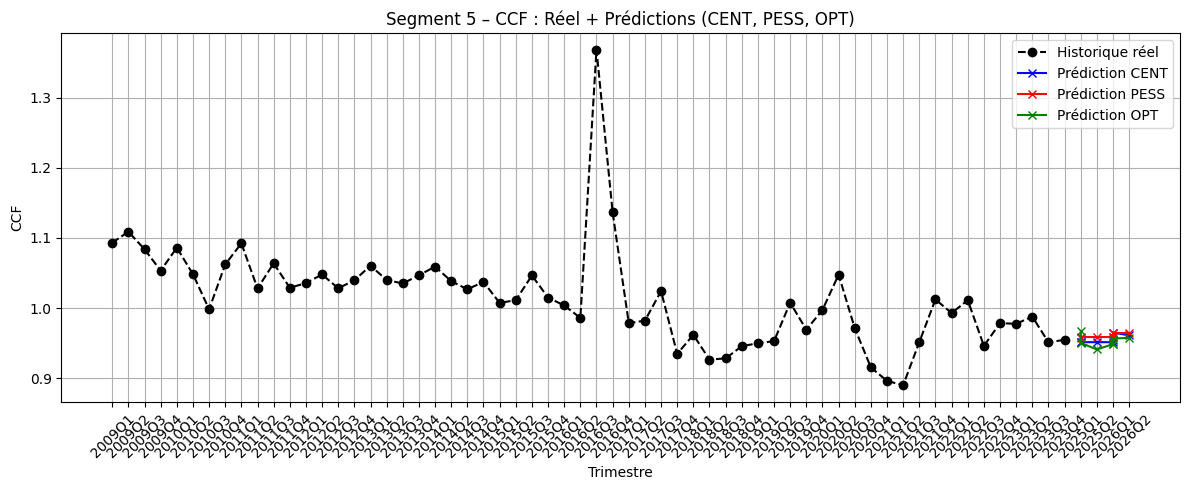

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Pour éviter les erreurs si segments est une liste
if isinstance(segments, list):
    segments_dict = {i + 1: df.copy() for i, df in enumerate(segments)}
else:
    segments_dict = segments

# Palette
couleurs = {"CENT": "blue", "PESS": "red", "OPT": "green"}

for seg in range(1, 6):
    fig, ax = plt.subplots(figsize=(12, 5))

    df_hist = segments_dict[seg].copy()
    df_hist["Indicateur_moyen_Brut"] = (
        df_hist["Indicateur_moyen_Brut"]
        .astype(str).str.replace(",", ".").astype(float)
    )
    df_hist = df_hist.dropna(subset=["Indicateur_moyen_Brut"]).reset_index(drop=True)

    # Ajout de la date si manquante
    if "date" not in df_hist.columns:
        nb_hist = len(df_hist)
        df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")

    df_hist["trimestre"] = pd.to_datetime(df_hist["date"]).dt.to_period("Q").astype(str)
    df_hist = df_hist.sort_values("date")

    # Tracé de la série réelle
    ax.plot(df_hist["trimestre"],
            df_hist["Indicateur_moyen_Brut"],
            label="Historique réel", marker="o", linestyle="--", color="black")

    # Tracé des prédictions
    for scenario in ["CENT", "PESS", "OPT"]:
        try:
            df_pred = results_scenarios[scenario][seg].copy()
            df_pred["date"] = pd.to_datetime(df_pred["date"])
            df_pred["trimestre"] = df_pred["date"].dt.to_period("Q").astype(str)
            df_pred = df_pred.sort_values("date")

            ax.plot(df_pred["trimestre"], df_pred["CCF_prédit"],
                    label=f"Prédiction {scenario}",
                    marker="x", linestyle="-", color=couleurs.get(scenario, None))
        except Exception as e:
            print(f"⚠️ Segment {seg} – Scénario {scenario} manquant ou erreur : {e}")

    ax.set_title(f"Segment {seg} – CCF : Réel + Prédictions (CENT, PESS, OPT)")
    ax.set_xlabel("Trimestre")
    ax.set_ylabel("CCF")
    ax.grid(True)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:23: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parse

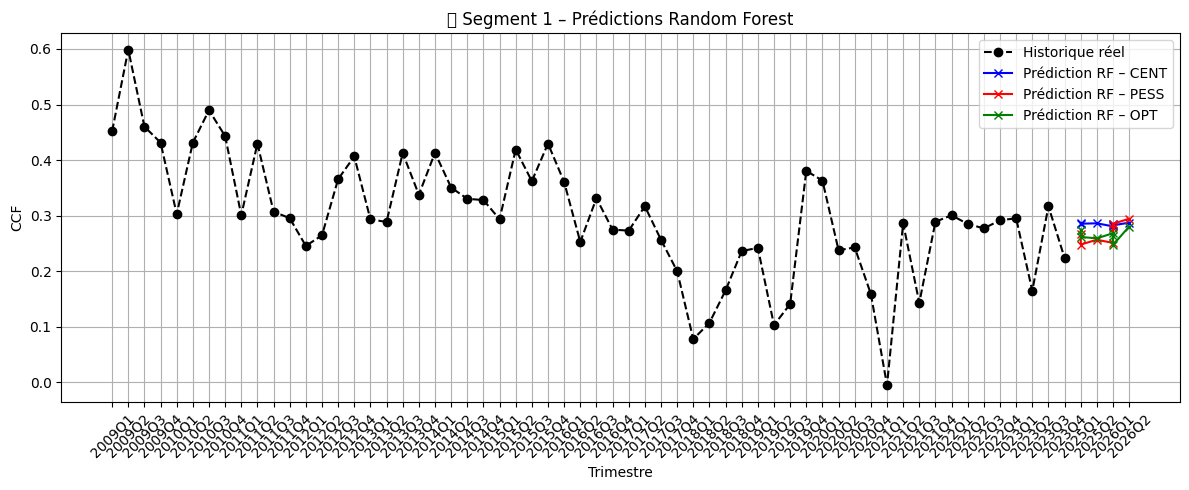

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:81: UserWarning: Glyph 1

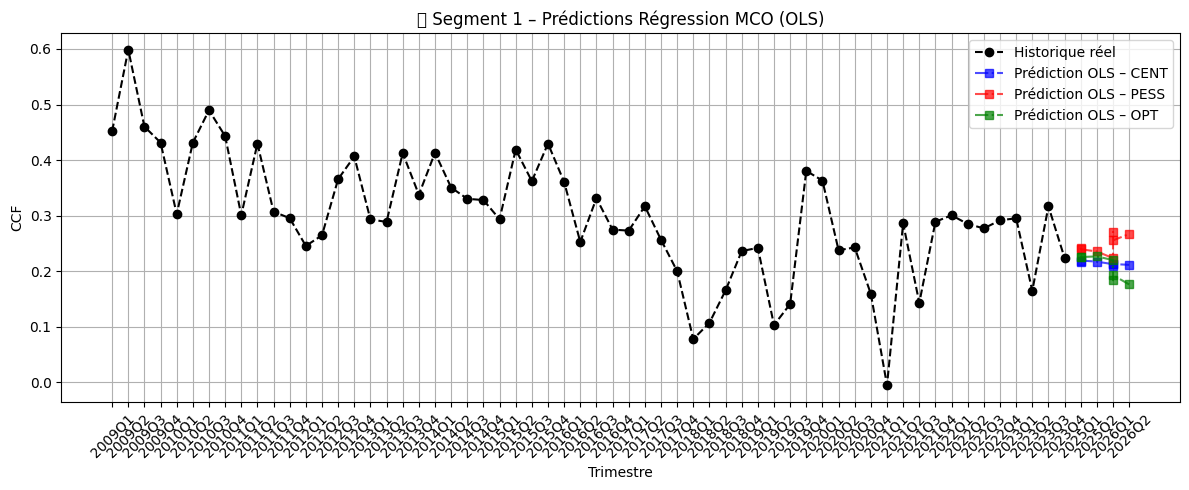

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:23: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parse

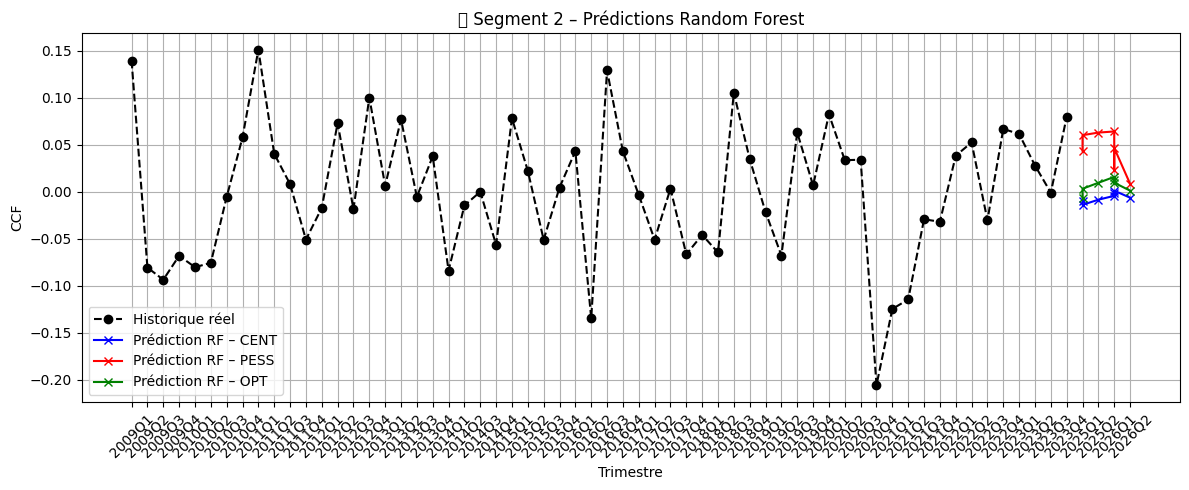

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:81: UserWarning: Glyph 1

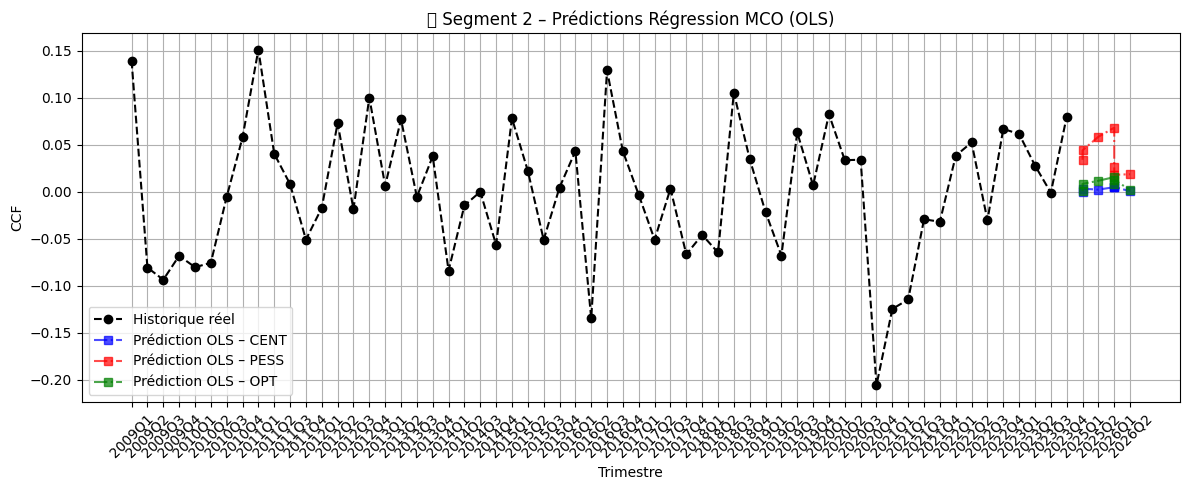

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:23: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parse

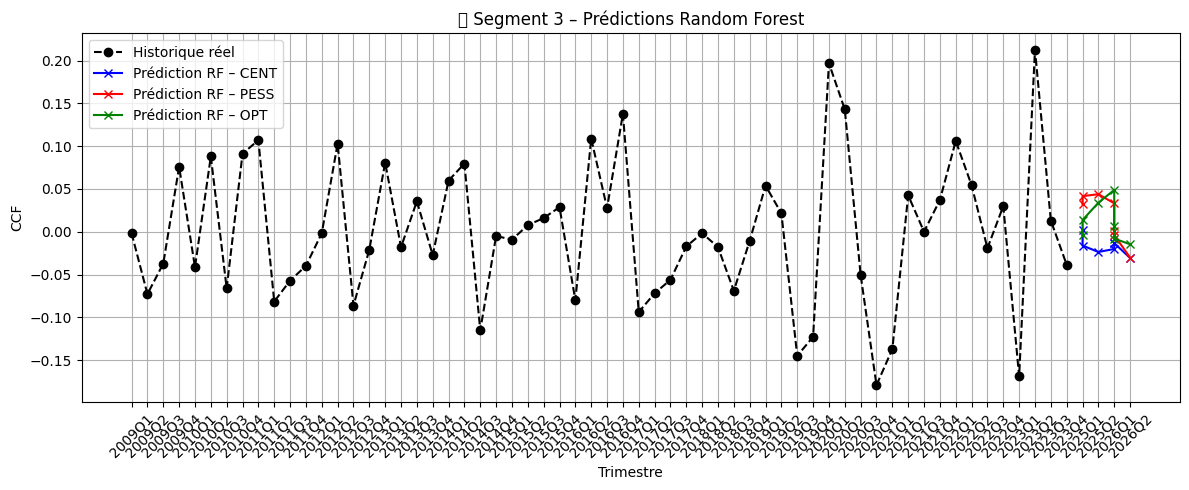

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:81: UserWarning: Glyph 1

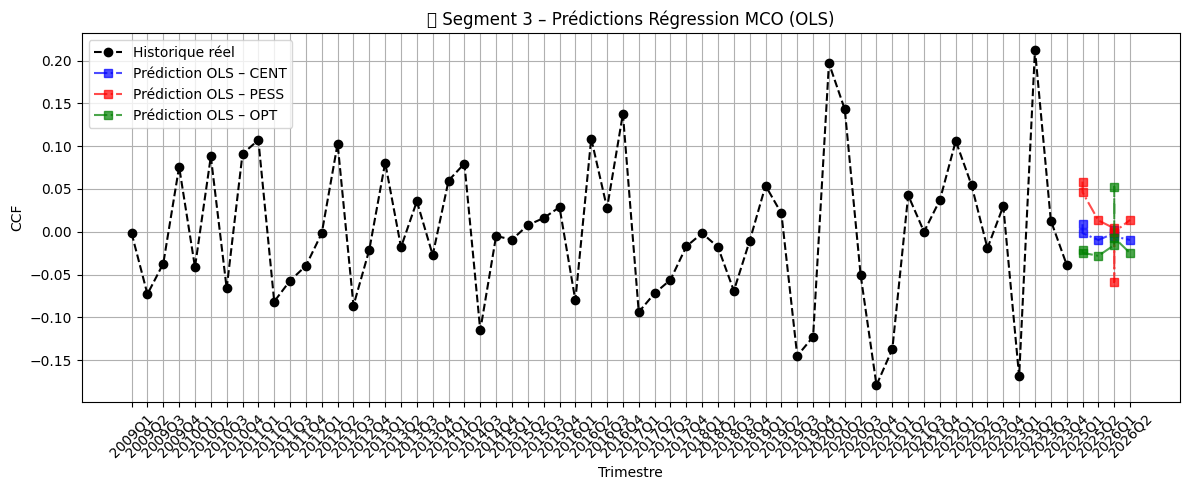

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:23: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parse

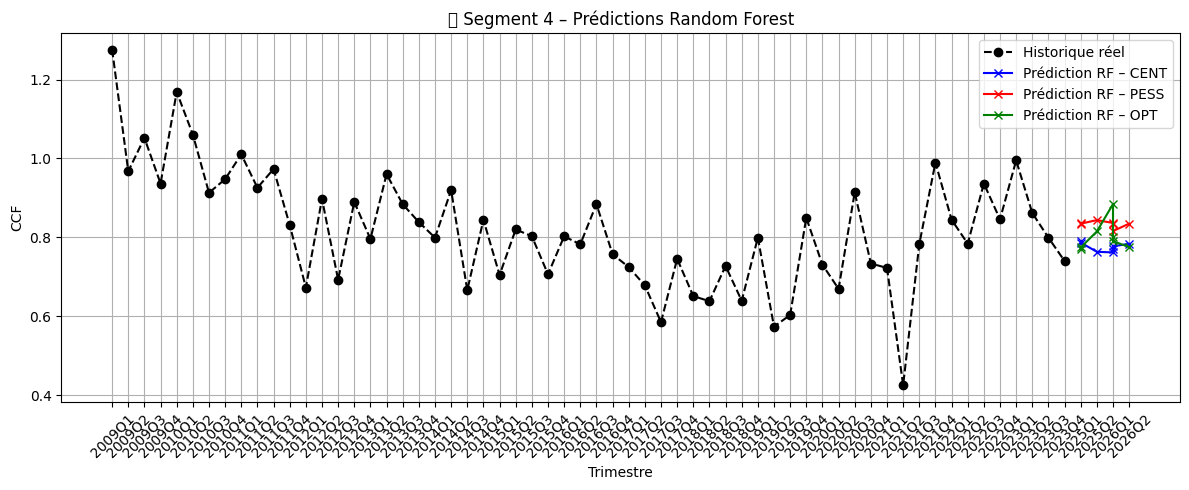

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:81: UserWarning: Glyph 1

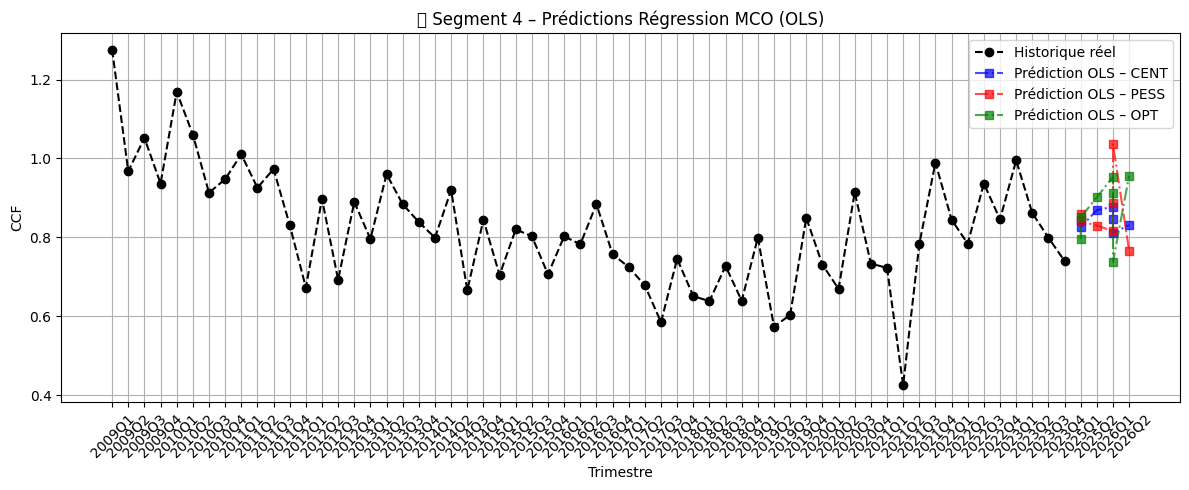

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:23: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:37: UserWarning: Could not infer format, so each element will be parse

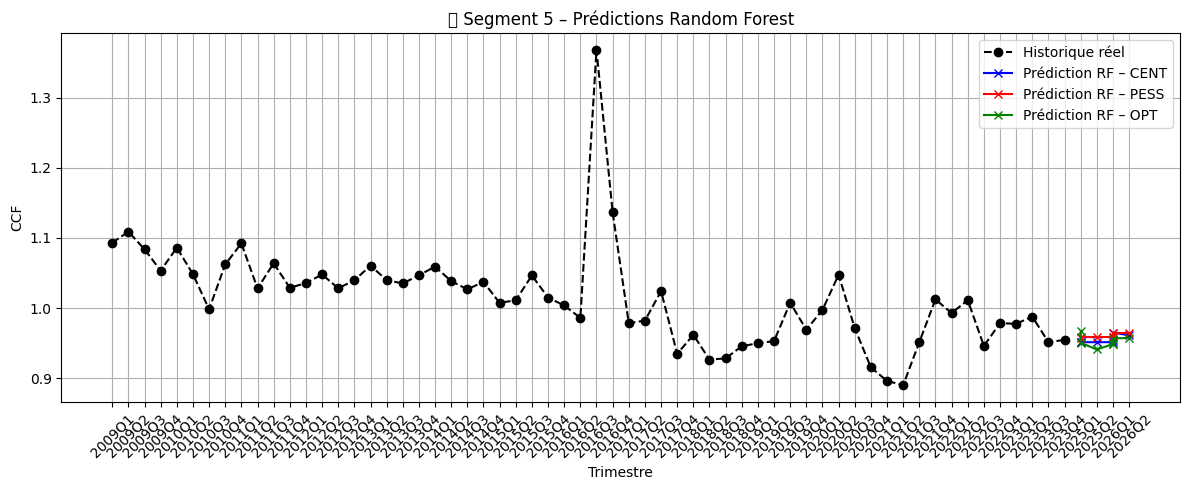

C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_19868\1278576881.py:81: UserWarning: Glyph 1

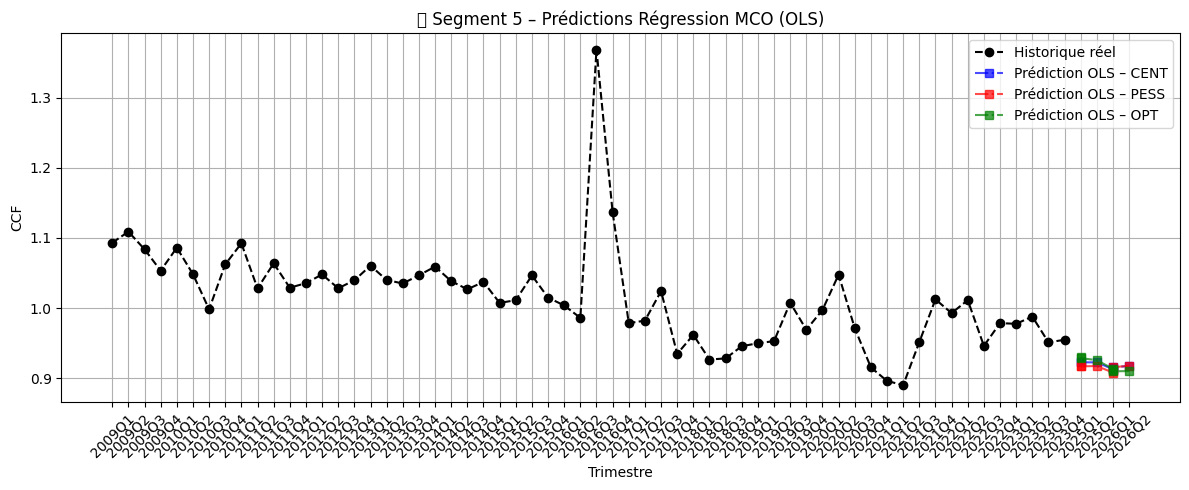

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Séparation des historiques
if isinstance(segments, list):
    segments_dict = {i + 1: df.copy() for i, df in enumerate(segments)}
else:
    segments_dict = segments

couleurs = {"CENT": "blue", "PESS": "red", "OPT": "green"}

for seg in range(1, 6):
    # === Données historiques
    df_hist = segments_dict[seg].copy()
    df_hist["Indicateur_moyen_Brut"] = (
        df_hist["Indicateur_moyen_Brut"]
        .astype(str).str.replace(",", ".").astype(float)
    )
    df_hist = df_hist.dropna(subset=["Indicateur_moyen_Brut"]).reset_index(drop=True)

    if "date" not in df_hist.columns:
        nb_hist = len(df_hist)
        df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")

    df_hist["trimestre"] = pd.to_datetime(df_hist["date"]).dt.to_period("Q").astype(str)
    df_hist = df_hist.sort_values("date")

    # === Graph RF
    fig_rf, ax_rf = plt.subplots(figsize=(12, 5))
    ax_rf.plot(df_hist["trimestre"],
               df_hist["Indicateur_moyen_Brut"],
               label="Historique réel", marker="o", linestyle="--", color="black")

    for scenario in ["CENT", "PESS", "OPT"]:
        try:
            df_pred = results_models[scenario][seg].copy()
            df_pred["date"] = pd.to_datetime(df_pred["date"])
            df_pred["trimestre"] = df_pred["date"].dt.to_period("Q").astype(str)
            df_pred = df_pred.sort_values("date")

            ax_rf.plot(df_pred["trimestre"], df_pred["CCF_RF"],
                       label=f"Prédiction RF – {scenario}",
                       marker="x", linestyle="-", color=couleurs.get(scenario))
        except Exception as e:
            print(f"⚠️ RF – Segment {seg} – Scénario {scenario} : {e}")

    ax_rf.set_title(f"📈 Segment {seg} – Prédictions Random Forest")
    ax_rf.set_xlabel("Trimestre")
    ax_rf.set_ylabel("CCF")
    ax_rf.grid(True)
    ax_rf.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # === Graph OLS
    fig_ols, ax_ols = plt.subplots(figsize=(12, 5))
    ax_ols.plot(df_hist["trimestre"],
                df_hist["Indicateur_moyen_Brut"],
                label="Historique réel", marker="o", linestyle="--", color="black")

    for scenario in ["CENT", "PESS", "OPT"]:
        try:
            df_pred = results_models[scenario][seg].copy()
            df_pred["date"] = pd.to_datetime(df_pred["date"])
            df_pred["trimestre"] = df_pred["date"].dt.to_period("Q").astype(str)
            df_pred = df_pred.sort_values("date")

            ax_ols.plot(df_pred["trimestre"], df_pred["CCF_OLS"],
                        label=f"Prédiction OLS – {scenario}",
                        marker="s", linestyle="-.", color=couleurs.get(scenario), alpha=0.7)
        except Exception as e:
            print(f"⚠️ OLS – Segment {seg} – Scénario {scenario} : {e}")

    ax_ols.set_title(f"📉 Segment {seg} – Prédictions Régression MCO (OLS)")
    ax_ols.set_xlabel("Trimestre")
    ax_ols.set_ylabel("CCF")
    ax_ols.grid(True)
    ax_ols.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
